# Prepare patches

> Methods to prepare patches of input image

In [ ]:
#| default_exp patch

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import torch
from torch import nn
import torch.functional as F
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

import yaml
from PIL import Image
from fastcore.basics import Path

In [ ]:
CONFIG_PATH = '../config.yml'
DATA_PATH = Path('../input') 

Load parameters from the config file. 

In [ ]:
config = yaml.safe_load(open(CONFIG_PATH))

In [ ]:
dset = datasets.CIFAR10(DATA_PATH, download=True, train=True)

Files already downloaded and verified


In [ ]:
images, targets = dset.data, dset.targets
len(images), len(targets)

(50000, 50000)

Prepare a small batch of images to test the image processing.

In [ ]:
images.shape

(50000, 32, 32, 3)

Sample a bunch of points and select those as indices of the image for training.

In [ ]:
image_idx = np.random.randint(low=0, high=len(images), size=3)

In [ ]:
# corresponding labels
targets = [targets[t] for t in image_idx]
targets

[3, 2, 4]

What are the classes we are dealing with?

In [ ]:
#| export
from fastcore.xtras import dict2obj
from fastcore.basics import filter_dict, filter_values, val2idx

In [ ]:
# dict2obj lets you dotify dicts or nested dicts
clsidx = dict2obj(dset.class_to_idx)
clsidx.bird 

2

In [ ]:
# filter the dict based on a function that checks k and v
filter_dict(clsidx, lambda k,v: v in targets)

{'bird': 2, 'cat': 3, 'deer': 4}

In [ ]:
# filters based on just the values
filter_values(clsidx, lambda v: v in targets)

{'bird': 2, 'cat': 3, 'deer': 4}

In [ ]:
targets[0]

3

In [ ]:
clsidx

```json
{ 'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9}
```

In [ ]:
in_ch = config["patch"]["in_ch"]
out_ch = config["patch"]["out_ch"]

In [ ]:
# size of each small patch
patch_size = config['patch']['size']
patch_size

16

In [ ]:
images.shape[1:]

(32, 32, 3)

In [ ]:
images = torch.Tensor(images[image_idx])
images = images/255.
images.shape

torch.Size([3, 32, 32, 3])

Increase image size to match with ViT paper $224\times 224$

In [ ]:
#| export
import torchvision.transforms as T

In [ ]:
hw = config['data']['hw']
augs = T.Resize(hw)
augs

Resize(size=[224, 224], interpolation=bilinear, max_size=None, antialias=None)

In [ ]:
images = augs(images.permute(0, 3, 1, 2))
images.shape

torch.Size([3, 3, 224, 224])

In [ ]:
n_channels, height, width = images.shape[1:]
print(f"image height: {height}, width: {width}, channels: {n_channels}")
assert height==width

image height: 224, width: 224, channels: 3


Number of patches is also called the sequence length in the original Transformers paper.

In [ ]:
n_patches = (height*width)/(patch_size**2)
print(f"number of {patch_size}x{patch_size} patches in an image of shape {images.shape[1:]}: {n_patches}")

number of 16x16 patches in an image of shape torch.Size([3, 224, 224]): 196.0


In [ ]:
shape_sequence = (n_patches, (patch_size**2)*in_ch)
print(f"shape of flattened 2D sequence: {shape_sequence}")

shape of flattened 2D sequence: (196.0, 768)


# Prepare flattened 2D sequence

Display a sample image with title.

In [ ]:
idx=2

Text(0.5, 1.0, "{'deer': 4}")

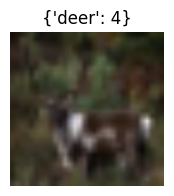

In [ ]:
plt.figure(figsize=(2, 2))
plt.imshow(images[idx].permute(1, 2, 0))
plt.axis('off')
label = filter_values(clsidx, lambda v: v is targets[idx])
plt.title(label=label)

Use a convolutional layer to prepare a patched image.

In [ ]:
conv2d = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=patch_size, stride=patch_size)

PyTorch requires images in BCHW format.

In [ ]:
images.shape

torch.Size([3, 3, 224, 224])

In [ ]:
patched_image = conv2d(images)
patched_image.shape

torch.Size([3, 768, 14, 14])

In [ ]:
patched_image = patched_image.flatten(start_dim=2, end_dim=-1)
patched_image.shape # flatten to 2D
# permute to match the expected shape
patched_image = patched_image.permute(0, 2, 1)
patched_image.shape

torch.Size([3, 196, 768])

# Prepare class embedding
The goal is to prepend to the flattened sequence a new item that encodes the class.
Inorder to create class embedding, we need to know the embedding dimension as well since each of the embeddings is associated to the class as well.

In [ ]:
bs, seq_len, embed_dim = patched_image.shape
print(f"shape of embed dim (D): {embed_dim}")
print(f"shape of sequence length (N): {seq_len}")

shape of embed dim (D): 768
shape of sequence length (N): 196


In [ ]:
# for all patches in the image prepend a learnable class token 
# this is a common token, not separated by items in batch
class_token = nn.Parameter(torch.ones(1, 1, embed_dim), requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [ ]:
class_token.shape, patched_image.shape

(torch.Size([1, 1, 768]), torch.Size([3, 196, 768]))

In [ ]:
#| export
from einops import repeat

In [ ]:
# class tokens are shared among batch items
class_tokens = repeat(class_token, '1 1 d -> bs 1 d', bs = bs)
class_tokens.shape

torch.Size([3, 1, 768])

In [ ]:
torch.concat([class_tokens, patched_image], dim=1)

tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [-1.9330e-01,  5.3230e-01,  4.1072e-01,  ..., -7.1345e-02,
          -3.6855e-02, -5.7116e-03],
         [-2.3731e-01,  6.1622e-01,  4.8126e-01,  ..., -3.7821e-02,
          -2.9133e-02, -4.7400e-02],
         ...,
         [-8.0137e-02,  1.7678e-01,  1.2428e-01,  ..., -3.5896e-02,
          -3.9498e-02,  9.8821e-03],
         [-5.6294e-02,  1.7154e-01,  9.5655e-02,  ..., -4.0395e-02,
          -2.8825e-02, -8.3997e-04],
         [-5.4865e-02,  1.5447e-01,  8.8190e-02,  ..., -2.9878e-02,
          -3.1163e-02, -7.8464e-04]],

        [[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [-2.1967e-02,  1.6781e-01,  1.1162e-01,  ..., -1.2469e-01,
          -8.1662e-02,  1.2122e-01],
         [-1.9772e-02,  1.7202e-01,  1.1616e-01,  ..., -1.3429e-01,
          -8.4445e-02,  1.2937e-01],
         ...,
         [-2.6714e-01,  4

In [ ]:
patched_image = torch.concat([class_tokens, patched_image], dim=1)
patched_image.shape

torch.Size([3, 197, 768])

# Prepare positional embedding
This should now be same for all images in the batch. Add positional embedding for each patch. 

In [ ]:
# +1 for the extra class token added above
pos_token = nn.Parameter(torch.ones(1, int(seq_len)+1, embed_dim), requires_grad=True)
pos_token.shape

torch.Size([1, 197, 768])

Add the positional embedding to create the input $z_l^0$

In [ ]:
patched_image += pos_token

# PatchEmbedding Module 
PyTorch module that does all of the above.

In [ ]:
#| export

class PatchEmbedding(nn.Module):
    def __init__(self, config, channel_first=True) -> None:
        super().__init__()
        # patch related
        patch_size = config["patch"]["size"]
        in_ch = config["patch"]["in_ch"]
        embed_dim = config["patch"]["out_ch"] # out_ch
        seq_len = config["patch"]["n"] # n_patches
        # data related
        bs = config["data"]["bs"]
        
        self.conv2d = nn.Conv2d(
            in_channels=in_ch,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )
        self.channel_first = channel_first
        self.flatten = nn.Flatten(start_dim=2, end_dim=-1)
        # class tokens are shared among batch items
        # 1, 1, embed_dim
        self.cls_token = nn.Parameter(torch.ones(1, 1, embed_dim), requires_grad=True)     
        # for all images in the batch what is the order of patches
        # 1, n_patches+1, embed_dim
        self.pos_embed = nn.Parameter(torch.ones(1, int(seq_len)+1, embed_dim), requires_grad=True)

    def forward(self, x):
        bs = x.shape[0]
        # repeat at each forward, not as learnable, need a class token with (1, 1, embed_dim)
        cls_tokens = repeat(self.cls_token, '1 1 d -> bs 1 d', bs = bs)
        if not self.channel_first:
            x = x.permute(0, 3, 1, 2)
        x = self.flatten(self.conv2d(x)).permute(0, 2, 1) # (bs, seq_len, embed_dim)
        x = torch.concat([cls_tokens, x], dim=1) + self.pos_embed
        return x


In [ ]:
PatchEmbedding(config, channel_first=True)(images).shape

torch.Size([3, 197, 768])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()